In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
def get_images(directory: str, label: str) -> list:
    """return all images in a directory as a list"""
    return [(os.path.join(directory,item), label) for item in os.listdir(directory)]

In [4]:
def get_images_without_label(directory: str) -> list:
    """return all test images in a directory as a list"""
    return [os.path.join(directory, item) for item in os.listdir(directory)]

In [5]:
def create_dataframe(data: list) -> pd.DataFrame:
    """create images from a list and return a dataframe"""
    df = pd.DataFrame()
    image = []
    label = []
    for item in data:
        image.append(plt.imread(item[0]))
        label.append(item[1])
    df["image"] = image
    df["label"] = label
    
    return df

In [6]:
def create_dataframe_without_label(data: list) -> pd.DataFrame:
    """create images from a list and return a dataframe"""
    df = pd.DataFrame()
    image = []
    for item in data:
        image.append(plt.imread(item))
    df["image"] = image
    
    return df

In [7]:
train_clean_folder = "../images/train/clean/"
train_messy_folder = "../images/train/messy/"

test_folder = "../images/test/"

val_clean_folder = "../images/val/clean/"
val_messy_folder = "../images/val/messy/"

In [8]:
tem = get_images(train_clean_folder,"clean")

In [9]:
cle = create_dataframe(tem)

In [10]:
mes = get_images(train_messy_folder, "messy")
mes_df = create_dataframe(mes)

In [11]:
mes_df = mes_df.set_index(pd.Index(range(96,192)))

In [12]:
train_df = pd.concat([cle, mes_df])

In [13]:
train_df["label"].value_counts()

messy    96
clean    96
Name: label, dtype: int64

### DEFINE MODEL ARCHITECTURE

In [14]:
from tensorflow.keras import layers

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   192 non-null    object
 1   label   192 non-null    object
dtypes: object(2)
memory usage: 3.1+ KB


In [16]:
train_df["image"][0].shape

(299, 299, 3)

In [17]:
train_df = train_df.sample(frac=1, random_state=1)

In [18]:
X = np.array([item for item in train_df["image"]])
X.shape

(192, 299, 299, 3)

In [19]:
from tensorflow.keras.utils import to_categorical

In [20]:
Y = train_df["label"].map(lambda x: 1 if x == "clean" else 0)

In [21]:
sam_t = get_images_without_label(test_folder)

test_df = create_dataframe_without_label(sam_t)

In [22]:
val_clean_list = get_images(val_clean_folder, "clean")
val_messy_list = get_images(val_messy_folder, "messy")

val_clean_df = create_dataframe(val_clean_list)
val_messy_df = create_dataframe(val_messy_list).set_index(pd.Index(range(10,20)))

In [23]:
validation_df = pd.concat([val_clean_df, val_messy_df]).sample(frac=1, random_state=1)

In [24]:
val_data = np.array([item for item in validation_df["image"]])

In [25]:
val_test = validation_df["label"].map(lambda x: 1 if x == "clean" else 0)

In [26]:
model = keras.Sequential()

model.add(layers.Conv2D(256, (3,3), activation="relu", input_shape=(299,299,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(128, (3,3), activation="relu"))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 256)     7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 256)     0         
_________________________________________________________________
dropout (Dropout)            (None, 148, 148, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 128)     295040    
_________________________________________________________________
flatten (Flatten)            (None, 2728448)           0         
_________________________________________________________________
dense (Dense)                (None, 64)                174620736 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [28]:
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [34]:
history = model.fit(
    x=X,y=Y,
    batch_size=64,
    epochs=10,
    validation_data=(val_data, val_test),
    verbose=0
)

Epoch 1/5
48/48 [==============================] - 37s 711ms/step - loss: 1.4952 - accuracy: 0.5521 - val_loss: 0.6782 - val_accuracy: 0.7000
Epoch 2/5
48/48 [==============================] - 40s 837ms/step - loss: 0.5847 - accuracy: 0.7188 - val_loss: 0.7240 - val_accuracy: 0.5000
Epoch 3/5
48/48 [==============================] - 39s 807ms/step - loss: 0.3760 - accuracy: 0.8802 - val_loss: 0.8241 - val_accuracy: 0.5000
Epoch 4/5
48/48 [==============================] - 37s 765ms/step - loss: 0.1162 - accuracy: 0.9635 - val_loss: 1.0642 - val_accuracy: 0.6500
Epoch 5/5
48/48 [==============================] - 39s 808ms/step - loss: 0.0657 - accuracy: 0.9792 - val_loss: 1.3725 - val_accuracy: 0.6000


In [37]:
history_dict = history.history

In [38]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

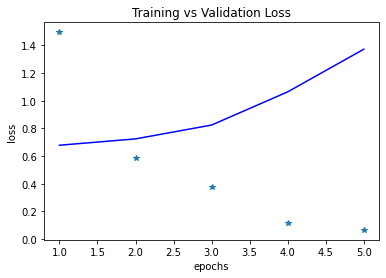

In [40]:
#plot training and validation loss
epochs = range(1,6)
plt.plot(epochs, history_dict["loss"],"*",label="training_loss")
plt.plot(epochs, history_dict["val_loss"],"b", label="validation_loss")
plt.title("Training vs Validation Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

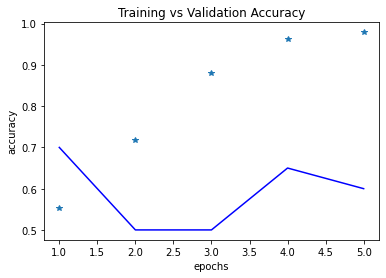

In [41]:
plt.plot(epochs, history_dict["accuracy"],"*",label="training_accuracy")
plt.plot(epochs, history_dict["val_accuracy"],"b", label="validation_accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()